In [173]:
!pip install pyyaml
!pip install matplotlib-venn
!pip install tables
!pip install networkx

     |████████████████████████████████| 1.6MB 14.0MB/s eta 0:00:01


In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
import datetime
import dask.dataframe as dd
import tables
from scipy.spatial.distance import cosine

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

import networkx as nx
import networkx.algorithms.community as nxcom

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup'>Setup</a>
------------------------------------
### 2. <a href='#null'>Null values</a>
### 3. <a href='#ok'>`column`: ok</a>
### 4. <a href='#seda'>Spec EDA</a>
### 5. <a href='#sinp'>Sample Inputs for each column</a>
------------------------------------
### 6. <a href='#conda'>`column`: conda - parse</a>
### 7. <a href='#pip'>`column`: pip - parse</a>
### 8. <a href='#dpdf'>Building a dependency df on conda/pip</a>
------------------------------------
### 9. <a href='#lpick'>Load pickle</a>
### 10. <a href='#leda'>Library EDA</a>
### 11. <a href='#veda'>Library Version EDA</a>
### 12. <a href='#cpdiff'>Conda/Pip difference</a>
------------------------------------
### 13. <a href='#hgg'>Heatmap Graph Generation</a>
### 14. <a href='#nex'>NetworkX Setup</a>
### 15. <a href='#nv'>Bokeh Visualizations</a>

<a name='setup'></a>
## 1. Setup

<br>

In [3]:
con = sqlite3.connect('binder-specs.sqlite')
df = pd.read_sql('SELECT * FROM specs', con)

In [4]:
df.columns

Index(['ok', 'remote', 'git_ref', 'git_commit', 'apt', 'conda', 'pip',
       'pipfile', 'docker', 'setup', 'julia', 'r', 'nix', 'postbuild', 'start',
       'runtime', 'ls', 'resolved_commit'],
      dtype='object')

In [5]:
df

,ok,remote,git_ref,git_commit,apt,conda,pip,pipfile,docker,setup,julia,r,nix,postbuild,start,runtime,ls,resolved_commit
0,0,00Kai0/jupyter-book,master,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0,00quanta/practicalAI,master,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,0,00quanta/requirements,master,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,0,04x/instagramCracker,master,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,0,1-Nameless-1/Lign167,59804a761525c729b6b7965e0526f4b4b25d5ddd,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166074,1,mdpetters/MEA-412-Notebooks,master,,None,None,None,None,# Dockerfile for building Atmospheric-Physics-...,None,"name = ""Atmospheric Physics""\nuuid = ""13a5dcd1...",None,None,None,None,None,"{"".gitignore"": 12, "".travis.yml"": 822, ""Docker...",e0ff4987ab44c3574b78a5022d244e659cab64ba
166075,1,mdpetters/mdpetters.github.io,740205b0c280e5d3998a1b1adcfef795c6c44711,,None,None,None,None,None,None,None,None,None,None,None,None,"{"".ipynb_checkpoints"": {""Thar Dust Charge Corr...",740205b0c280e5d3998a1b1adcfef795c6c44711
166076,1,mdpiper/notebooks,master,,None,None,None,None,None,None,None,None,None,None,None,None,"{"".gitignore"": 1203, ""LICENSE"": 1067, ""README....",5f88f0d6e37eab7125cfded784fe64a07a2cfe73
166077,1,mdreck/mdreck.github.io,master,222338c70f1e76802bf36769bf3f95bd6940e07a,None,None,None,None,None,None,None,None,None,None,None,None,"{""CHANGELOG.md"": 55635, ""Gemfile"": 37, ""LICENS...",222338c70f1e76802bf36769bf3f95bd6940e07a


In [6]:
dash = '-' * 60

<a name='null'></a>
## 2. Null values
Printing the number of null values in each column.

<br>

In [7]:
print('{:<15s}{:>8s}{:>20s}'.format('Name', 'Null values', 'Null %'))
print(dash)
for col in df.columns:
    print('{:<15s}{:>8s}{:>20s}'.format(col, str(len(df[df[col].isnull()])), str(round(len(df[df[col].isnull()]) / len(df), 2))))

Name           Null values              Null %
------------------------------------------------------------
ok                    0                 0.0
remote                0                 0.0
git_ref               0                 0.0
git_commit            0                 0.0
apt              155452                0.94
conda            131613                0.79
pip              111902                0.67
pipfile          165166                0.99
docker           155892                0.94
setup            155002                0.93
julia            163536                0.98
r                161233                0.97
nix              166044                 1.0
postbuild        144966                0.87
start            162859                0.98
runtime          157931                0.95
ls                 9825                0.06
resolved_commit   19334                0.12


The "" values were considered null but they are mainly applied for git_commit, which doesn't really matter too much (an empty commit is still a commit).

In [8]:
print('{:<15s}{:>8s}{:>20s}'.format('Name', 'Non-null values', 'Non-null %'))
print(dash)

for col in df.columns:
    nonnull = len(df[~df[col].isnull()][df[col] != ""][df[col] != "\n"])
    print('{:<15s}{:>8s}{:>20s}'.format(col, str(nonnull), str(round(nonnull / len(df), 2))))


Name           Non-null values          Non-null %
------------------------------------------------------------
ok               166079                 1.0
remote           166079                 1.0
git_ref          166079                 1.0
git_commit       107113                0.64
apt               10436                0.06
conda             34463                0.21
pip               53721                0.32
pipfile             913                0.01
docker            10187                0.06
setup             11072                0.07
julia              2483                0.01
r                  4823                0.03
nix                  35                 0.0
postbuild         21024                0.13
start              3220                0.02
runtime            8130                0.05
ls               156254                0.94
resolved_commit  146745                0.88


Many of the columns list dependencies (conda, pip, apt, pipfile, setup, julia, r, nix, runtime) and are pretty rare occurrences, but it would be useful to look at how many entries have AT LEAST one form of dependency listed.

In [9]:
list_of_cols = ["conda", "pip", "apt", "pipfile", "setup", "julia", "r", "nix", "runtime"]
len(df[list_of_cols].dropna(thresh=1))

95598

<a name='ok'></a>
## 3. col: `ok`

Comparing the proportion of null values in entries where `ok`=1 against entries where `ok`=0.

<br>

In [10]:
sum(df["ok"])

146745

In [11]:
ok_df = df[df["ok"] == 1]
nok_df = df[df["ok"] == 0]

print('{:<15s}{:>8s}{:>20s}'.format('Name', 'Null in ok=1', 'Null in ok=0'))
print(dash)
for col in df.columns:
    print('{:<15s}{:>10s}{:>20s}'.format(col, str(round(len(ok_df[ok_df[col].isnull()]) / len(ok_df), 2)), 
                                        str(round(len(nok_df[nok_df[col].isnull()]) / len(nok_df), 2))))


Name           Null in ok=1        Null in ok=0
------------------------------------------------------------
ok                    0.0                 0.0
remote                0.0                 0.0
git_ref               0.0                 0.0
git_commit            0.0                 0.0
apt                  0.93                 1.0
conda                0.77                 1.0
pip                  0.63                 1.0
pipfile              0.99                 1.0
docker               0.93                 1.0
setup                0.92                 1.0
julia                0.98                 1.0
r                    0.97                 1.0
nix                   1.0                 1.0
postbuild            0.86                 1.0
start                0.98                 1.0
runtime              0.94                 1.0
ls                    0.0                0.51
resolved_commit       0.0                 1.0


<a name='seda'></a>
## 4. Spec EDA

<br>

ok               146745                 1.0
remote           146745                 1.0
git_ref          146745                 1.0
git_commit        98329                0.67
apt               10436                0.07
conda             34463                0.23
pip               53721                0.37
pipfile             913                0.01
docker            10187                0.07
setup             11072                0.08
julia              2483                0.02
r                  4823                0.03
nix                  35                 0.0
postbuild         21024                0.14
start              3220                0.02
runtime            8130                0.06
ls               146745                 1.0
resolved_commit  146745                 1.0


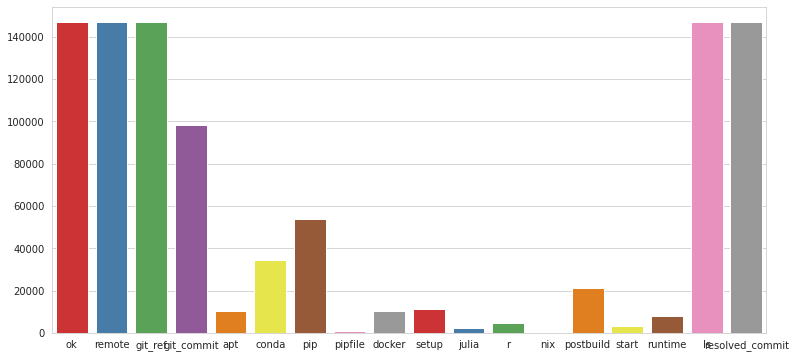

In [12]:
nnull_x, nnull_y = [], []
for col in ok_df.columns:
    nonnull = len(ok_df[~ok_df[col].isnull()][ok_df[col] != ""][ok_df[col] != "\n"])
    print('{:<15s}{:>8s}{:>20s}'.format(col, str(nonnull), str(round(nonnull / len(ok_df), 2))))
    nnull_x.append(col)
    nnull_y.append(nonnull)
    
plt.figure(figsize=(12.8,6))
plot = sns.barplot(x=nnull_x, y=nnull_y, palette="Set1")

As the `ok`=0 entries have 100% null values in most columns, will exclude from future visualizations.

We expect the entries with at least one dependency col to be the same, and find that roughly **65%** of the `ok_df` entries satisfy this.

In [13]:
list_of_cols = ["conda", "pip", "apt", "pipfile", "setup", "julia", "r", "nix", "runtime"]
len(ok_df[list_of_cols].dropna(thresh=1)), len(ok_df[list_of_cols].dropna(thresh=1)) / len(ok_df)

(95598, 0.6514566084023306)

In particular, we are interested in seeing the % for conda/pip. We use a new total where at least one dependency is present. To get the total conda+pip columns, we can do **A+B-AB**, since the overlap is considered twice in A+B. Then, divide this by the total to get a proportion.

In [14]:
venn_total = len(ok_df[list_of_cols].dropna(thresh=1))
venn_CP = len(df[~df['pip'].isnull()][~df['conda'].isnull()])
venn_C = len(df[~df['pip'].isnull()][df['conda'].isnull()])
venn_P = len(df[df['pip'].isnull()][~df['conda'].isnull()])
venn_none = venn_total - venn_C - venn_P

print(venn_C + venn_P - venn_CP, (venn_C + venn_P - venn_CP) / venn_total)

77705 0.8128308123600912


So, **81%** of entries with at least one dependency use conda/pip. We can also represent this in a venn diagram, with percentages to label the portions, where "The subsets parameter is a 3 element list where the numbers 30, 10, 5 correspond to Ab, aB, AB."

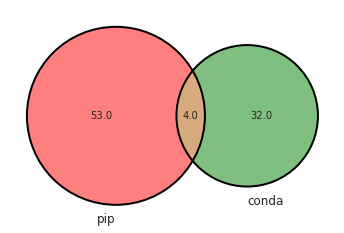

In [15]:
vA, vB, vAB = round(venn_C / venn_total, 2) * 100, round(venn_P / venn_total, 2) * 100, round(venn_CP / venn_total, 2) * 100
venn2(subsets = (vA, vB, vAB), set_labels = ('pip', 'conda'), alpha = 0.5)
venn2_circles(subsets = (vA, vB, vAB));

<a name='sinp'></a>
## 5. Sample inputs for each column

<br>

In [16]:
class color:
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'


for col in ok_df.columns:
    col_inputs = ok_df[~ok_df[col].isnull()][ok_df[col] != ""][ok_df[col] != "\n"][col].reset_index()[col]
    print(color.BOLD + color.RED + "COLUMN: " + col + color.END)
    
    for i in np.arange(5):
        print(str(i) + " " + str(col_inputs[i]))
        
    print()
    print(dash)
    print()

COLUMN: ok
0 1
1 1
2 1
3 1
4 1

------------------------------------------------------------

COLUMN: remote
0 mdsmith44/Army_ORSA_Python_Data_Analysis_Tutorial
1 mdsmith44/Git-Test
2 mdssmith/binder_test
3 mdsumner/polar-mapping-oghub
4 me2d09/coviduberounky

------------------------------------------------------------

COLUMN: git_ref
0 master
1 master
2 master
3 master
4 master

------------------------------------------------------------

COLUMN: git_commit
0 ab1be186a74c81c83f863bc3b6258fee46eeca56
1 9267f689d1935f5670e00d63b4f9639226f599ec
2 6464ab1b75787590096275bf36b6e3035f23d2ab
3 f4d256f2e4e8688261871073f9e7f87cacd7486c
4 562d55fbc439fbf936f32fcb9e09fbfa1f145936

------------------------------------------------------------

COLUMN: apt
0 vim

1 vim

2 openjdk-8-jdk
3 openjdk-8-jdk
4 openjdk-8-jdk

------------------------------------------------------------

COLUMN: conda
0 name: binder-example
dependencies:
    - python=3.7
    - numpy
    - pandas
    - matplotlib
1 # Conda

COLUMN: start
0 #!/usr/bin/env python3
import sys
import shutil
import os

argv = sys.argv[1:] + ['--config', 'binder/jupyter_notebook_config.py']
print(argv)

os.execv(shutil.which(argv[0]), argv)
1 #!/usr/bin/env python3
import sys
import shutil
import os

argv = sys.argv[1:] + ['--config', 'binder/jupyter_notebook_config.py']
print(argv)

os.execv(shutil.which(argv[0]), argv)
2 #!/usr/bin/env python3
import sys
import shutil
import os

argv = sys.argv[1:] + ['--config', 'binder/jupyter_notebook_config.py']
print(argv)

os.execv(shutil.which(argv[0]), argv)
3 #!/usr/bin/env python3
import sys
import shutil
import os

argv = sys.argv[1:] + ['--config', 'binder/jupyter_notebook_config.py']
print(argv)

os.execv(shutil.which(argv[0]), argv)
4 #!/usr/bin/env python3
import sys
import shutil
import os

argv = sys.argv[1:] + ['--config', 'binder/jupyter_notebook_config.py']
print(argv)

os.execv(shutil.which(argv[0]), argv)

------------------------------------------------------------

COL

Or, to look at a particular column:

In [17]:
col='conda'
ok_df[~ok_df[col].isnull()][col].reset_index()[col].value_counts()

name: example-environment\nchannels:\n  - conda-forge\ndependencies:\n  - numpy\n  - psutil\n  - toolz\n  - matplotlib\n  - dill\n  - pandas\n  - partd\n  - bokeh\n  - dask\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

<a name='conda'></a>
## 6. col: `conda` - parse

 - .loc is simply way too slow past n>1000. Creating a temp df with .at and appending every 1000 entries to the main df.

<br>

In [31]:
def conda_parse(df, delete_indices, dp_df, dc_df, test_cap=9999999, benchmark=False):    
    conda_L = df[~df['conda'].isnull()]['conda'].reset_index()
    errors=0
    temp_df = pd.DataFrame()
    a = datetime.datetime.now()
    time_list = []
    for i in np.arange(min(test_cap, len(conda_L))):
        if (i % 1000 == 0):
            dp_df = dp_df.append(temp_df)
            temp_df = pd.DataFrame()
            if benchmark:
                b = datetime.datetime.now()
                c = b - a
                time_list.append(c.seconds)
                print(str(i) + " " + str(c.seconds))
                a = datetime.datetime.now()
        true_index = conda_L.at[i, "index"]
        try:
            dependency_list = yaml.load(conda_L['conda'][i], Loader=yaml.FullLoader)["dependencies"]
            for d_line in dependency_list:
                # will do something about this later
                if (type(d_line) != dict):
                    d_line = d_line.replace(" ", "").lower()
                    d_line = re.split('<=|>=|>|<|=', d_line, maxsplit=1)
                    d_name = d_line[0]
                    if (len(d_line) > 1):
                        d_type = d_line[1]
                        #dp_df.at[true_index, d_name] = d_type
                        temp_df.at[true_index, d_name] = d_type
                    else:
                        #dp_df.at[true_index, d_name] = "Default"
                        temp_df.at[true_index, d_name] = 'Default'
                        pass
                dc_df.at[true_index, 'conda'] = 1
        except:
            delete_indices.append(true_index)
    
    dp_df = dp_df.append(temp_df)
    if benchmark:
        b = datetime.datetime.now()
        c = b - a
        time_list.append(c.seconds)
        return delete_indices, dp_df, dc_df, time_list[1:]
    return delete_indices, dp_df, dc_df

delete_indices, dp_df, dc_df, conda_times = conda_parse(ok_df, [], pd.DataFrame(), pd.DataFrame(), 1500, True)

0 0
1000 15


In [19]:
dp_coln = 300
dp_df.columns[dp_coln : dp_coln + 100]

Index(['pytest-remotedata', 'python-dateutil', 'python-libarchive-c', 'pytz',
       'pywavelets', 'pywin32', 'pywinpty', 'pyzmq', 'qt', 'qtawesome',
       'qtconsole', 'qtpy', 'requests', 'rope', 'ruamel_yaml', 'send2trash',
       'setuptools', 'simplegeneric', 'singledispatch', 'sip', 'six', 'snappy',
       'snowballstemmer', 'sortedcollections', 'sortedcontainers', 'soupsieve',
       'sphinx', 'sphinxcontrib', 'sphinxcontrib-applehelp',
       'sphinxcontrib-devhelp', 'sphinxcontrib-htmlhelp',
       'sphinxcontrib-jsmath', 'sphinxcontrib-qthelp',
       'sphinxcontrib-serializinghtml', 'sphinxcontrib-websupport', 'spyder',
       'spyder-kernels', 'sqlalchemy', 'sqlite', 'statsmodels', 'tblib',
       'tensorflow-base', 'tensorflow-estimator', 'tensorflow-gpu-base',
       'termcolor', 'terminado', 'testpath', 'tk', 'toolz', 'tornado',
       'traitlets', 'typed-ast', 'unicodecsv', 'urllib3', 'vc',
       'vs2015_runtime', 'wcwidth', 'webencodings', 'werkzeug', 'wheel',
       

In [20]:
conda_times[1:]

[20]

<a name='pip'></a>
## 7. col: `pip` - parse

Notes:
 - Anything with a '#' is a comment, so the entire line (up until \n) after is discarded along with '#'.
 - There are large blocks of --hash where each hash is preceded by a '\\\n'. These can be removed with split. 
 - Same >=, <=, etc. rules apply as in conda, but instead of '=' it is now '=='.

<br>

In [21]:
df[~df['pip'].isnull()]['pip'].reset_index()['pip'][4].replace(" ", "").lower().split("\n")

['requests==2.24.0', 'beautifulsoup4==4.9.3', 'ufit==1.4.1', '']

In [22]:
"h#i"[:2]

'h#'

In [23]:
df[~df[col].isnull()][col].reset_index()[col][144]

'dependencies:\n  - python=3.8\n  - jupyter\n  - ipykernel\n  - plotly\n  - pandas\n'

In [32]:
def pip_parse(df, delete_indices, dp_df, dc_df, test_cap=9999999, benchmark=False):    
    pip_L = df[~df['pip'].isnull()]['pip'].reset_index()
    errors=0
    temp_df = pd.DataFrame()
    a = datetime.datetime.now()
    time_list = []
    for i in np.arange(min(test_cap, len(pip_L))):
        if (i % 1000 == 0):
            d = datetime.datetime.now()
            e = d - a
            dp_df = dp_df.append(temp_df)
            temp_df = pd.DataFrame()
            if benchmark:
                b = datetime.datetime.now()
                c = b - d
                time_list.append(c.seconds + e.seconds)
                print(str(i) + " " + str(e.seconds) + " " + str(c.seconds))
                a = datetime.datetime.now()
        true_index = pip_L.at[i, "index"]
        try:
            dependency_list = pip_L['pip'][i].replace(" ", "").lower().split("\n")
            for d_line in dependency_list:
                # will do something about this later
                if ((d_line != '') and (d_line[:2] != "--")):
                    d_line = d_line.split("#")[0]
                    d_line = re.split('<=|>=|>|<|==|@', d_line, maxsplit=1)
                    d_name = d_line[0]
                    if (len(d_line) > 1):
                        d_type = d_line[1]
                        #dp_df.loc[true_index, d_name] = d_type
                        temp_df.at[true_index, d_name] = d_type
                    else:
                        #dp_df.loc[true_index, d_name] = "Default"
                        temp_df.at[true_index, d_name] = "Default"
                dc_df.at[true_index, 'pip'] = 1
        except:
            delete_indices.append(true_index)
            
    dp_df = dp_df.append(temp_df)
    if benchmark:
        b = datetime.datetime.now()
        c = b - a
        time_list.append(c.seconds)
        return delete_indices, dp_df, dc_df, time_list[1:]
    return delete_indices, dp_df, dc_df

delete_indices, dp_df, dc_df, pip_times = pip_parse(ok_df, [], pd.DataFrame(), pd.DataFrame(), 100, True)

0 0 0


In [33]:
dp_coln = 100
dp_df.columns[dp_coln : dp_coln + 100]

Index(['wcwidth', 'webencodings', 'widgetsnbextension', 'zipp', 'mysqlclient',
       'pymysql', 'flask', 'xlsxwriter', 'voila', 'fastai2', 'pydicom',
       'git+https://github.com/fastai/fastai.git',
       'git+https://github.com/mwouts/jupytext.git',
       'jupyter_contrib_nbextensions', 'rise', 'scikit-learn', 'colorama',
       'cycler', 'kiwisolver', 'pywin32', 'simpy', 'jupyter-server-proxy',
       'uproot', 'lmfit', 'pandas_datareader', 'sagemaker', 'tensorflow',
       'keras', 'quandl', 'fastai',
       'https://download.pytorch.org/whl/cpu/torch-1.6.0%2bcpu-cp38-cp38-linux_x86_64.whl',
       'https://download.pytorch.org/whl/cpu/torchvision-0.7.0%2bcpu-cp38-cp38-linux_x86_64.whl',
       'twarc', 'twint', 'aiohttp', 'aiodns', 'cchardet', 'elasticsearch',
       'aiohttp_socks', 'schedule', 'geopy', 'emoji', 'jupyter-book',
       'ghp-import',
       'git+https://github.com/maria-antoniak/little-mallet-wrapper.git',
       'spacy', 'regex', 'little_mallet_wrapper', 'nltk

In [34]:
col='pip'
for i in np.arange(10):
    print()
    print()
    print(i)
    print(df[~df[col].isnull()][col].reset_index()[col][i])



0
numpy==1.18.5
pandas==1.0.5
fuzzywuzzy==0.18.0
bs4==0.0.1
geopandas==0.8.1
pycountry==20.7.3
matplotlib==3.2.2
seaborn==0.10.1
bokeh==2.2.3
sklearn==0.0
xlrd==1.2.0


1
requests==2.24.0
numpy==1.19.2
matplotlib==3.3.2


2
requests==2.24.0
numpy==1.19.2
matplotlib==3.3.2


3
requests==2.24.0 
beautifulsoup4==4.9.3 
ufit==1.4.2



4
requests==2.24.0 
beautifulsoup4==4.9.3 
ufit==1.4.1



5
requests==2.24.0 
beautifulsoup4==4.9.3 
ufit==1.4.2



6
requests==2.24.0 
beautifulsoup4==4.9.3 
ufit==1.4.1



7
# ========================================
#               DASH APP
# ========================================
dash #==1.11.0
dash-bootstrap-components #==0.9.2

# ========================================
#               DATA ANALYSIS
# ========================================
pandas #==1.0.3
numpy
scipy

iso3166
datetime

# ========================================
#               DATA VIZ
# ========================================
plotly #==4.6.0

# ==================================

In [27]:
yaml.load(df[~df[col].isnull()][col].reset_index()[col][15], Loader=yaml.FullLoader)

'voila fastai2>=0.0.16 pillow<7 packaging ipywidgets==7.5.1'

In [28]:
df[~df[col].isnull()][col].reset_index()[col][7]

'# ========================================\n#               DASH APP\n# ========================================\ndash #==1.11.0\ndash-bootstrap-components #==0.9.2\n\n# ========================================\n#               DATA ANALYSIS\n# ========================================\npandas #==1.0.3\nnumpy\nscipy\n\niso3166\ndatetime\n\n# ========================================\n#               DATA VIZ\n# ========================================\nplotly #==4.6.0\n\n# ========================================\n#           SERVER & DEPLOYMENT\n# ========================================\ngunicorn #==20.0.4\n\n'

In [29]:
[line for line in df[~df[col].isnull()][col].reset_index()[col][0] if "==" in line]

[]

In [30]:
install_reqs = parse_requirements(df[~df[col].isnull()][col].reset_index()[col][1], session='hack')
reqs = [str(ir.req) for ir in install_reqs]

InstallationError: Could not open requirements file: [Errno 2] No such file or directory: 'requests==2.24.0\nnumpy==1.19.2\nmatplotlib==3.3.2'

<a name='dpdf'></a>
## 8. Building a dependency df on conda/pip

<br>

In [35]:
dp_df, dc_df, delete_indices = pd.DataFrame(), pd.DataFrame(), []

delete_indices, dp_df, dc_df, conda_times = conda_parse(ok_df, delete_indices, dp_df, dc_df, 5000, benchmark=True)
delete_indices, dp_df, dc_df, pip_times = pip_parse(ok_df, delete_indices, dp_df, dc_df, 5000, benchmark=True)

#dp_df.drop(delete_indices)
#dc_df.drop(delete_indices)

dc_df = dc_df.fillna(0)

0 0
1000 15
2000 12
3000 11
4000 10
0 0 0
1000 7 0
2000 7 1
3000 9 1
4000 7 1


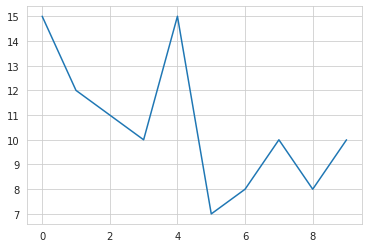

In [67]:
plt.plot(conda_times + pip_times)

In [64]:
dp_df

,python,numpy,pandas,matplotlib,gammapy,ipython,cython,jupyter,jupyterlab,pyyaml,...,cfunits,bottleneck~=1.3.1,ipypublish,enforce,showast,spotipy\r,keggdecoder,pandas_profiling,chinook,gifmaker
index,,,,,,,,,,,,,,,,,,,,,
13920,None,1.18.5,1.0.5,3.2.2,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13922,3.7,Default,Default,Default,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13925,None,1.19.2,None,3.3.2,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13926,None,1.19.2,None,3.3.2,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13927,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37026,3.7,Default,1,None,None,None,None,None,2.1.3,None,...,None,None,None,None,None,None,None,None,None,None
37027,3.7,Default,1,None,None,None,None,None,2.1.3,None,...,None,None,None,None,None,None,None,None,None,None
37028,3.7,Default,1,None,None,None,None,None,2.1.3,None,...,None,None,None,None,None,None,None,None,None,None


In [48]:
dp_df.index.unique()

Index(['python', 'numpy', 'pandas', 'matplotlib', 'gammapy', 'ipython',
       'cython', 'jupyter', 'jupyterlab', 'pyyaml',
       ...
       'cfunits', 'bottleneck~=1.3.1', 'ipypublish', 'enforce', 'showast',
       'spotipy\r', 'keggdecoder', 'pandas_profiling', 'chinook', 'gifmaker'],
      dtype='object', length=4318)

In [44]:
dp_df = dp_df.reset_index().groupby("index").first()
dp_df

In [ ]:
#dp_df.drop(dp_df.columns[delete_indices], axis=1, inplace=True)
#dc_df.drop(dc_df.columns[delete_indices], axis=1, inplace=True)

pickle file is 12GB after saving??? hdf5 has some weird error.

In [49]:
dp_df.to_pickle("./dp_df.pkl")
#dp_df.to_hdf('dp_df.h5', key='dp_df', mode='w')
#dp_df.to_csv("dp_df.csv")
#with pd.HDFStore('dpdf.h5',  mode='w') as store:
 #   store.append('dpdf', dp_df, data_columns= dp_df.columns, format='table')

<a name='lpick'></a>
## 9. Load pickle

<br>

In [57]:
r1 = datetime.datetime.now()

sdf = pd.read_pickle("./dp_df.pkl")
#sdf = pd.read_hdf('dp_df.h5', 'dp_df')
#sdf = pd.read_csv("dp_df.csv", error_bad_lines=False)

r2 = datetime.datetime.now()
print((r2 - r1).seconds)

3


In [55]:
sdf

,python,numpy,pandas,matplotlib,gammapy,ipython,cython,jupyter,jupyterlab,pyyaml,...,cfunits,bottleneck~=1.3.1,ipypublish,enforce,showast,spotipy\r,keggdecoder,pandas_profiling,chinook,gifmaker
index,,,,,,,,,,,,,,,,,,,,,
13920,None,1.18.5,1.0.5,3.2.2,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13922,3.7,Default,Default,Default,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13925,None,1.19.2,None,3.3.2,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13926,None,1.19.2,None,3.3.2,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13927,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37026,3.7,Default,1,None,None,None,None,None,2.1.3,None,...,None,None,None,None,None,None,None,None,None,None
37027,3.7,Default,1,None,None,None,None,None,2.1.3,None,...,None,None,None,None,None,None,None,None,None,None
37028,3.7,Default,1,None,None,None,None,None,2.1.3,None,...,None,None,None,None,None,None,None,None,None,None


<a name='leda'></a>
## 10. Library EDA

<br>

<AxesSubplot:>

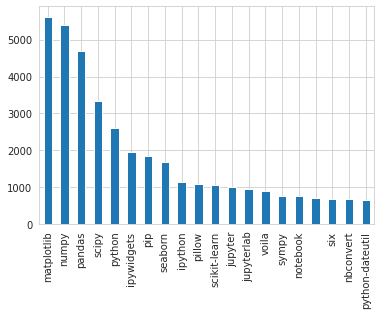

In [58]:
sdf.count().sort_values(ascending=False).head(20).plot.bar()

<AxesSubplot:>

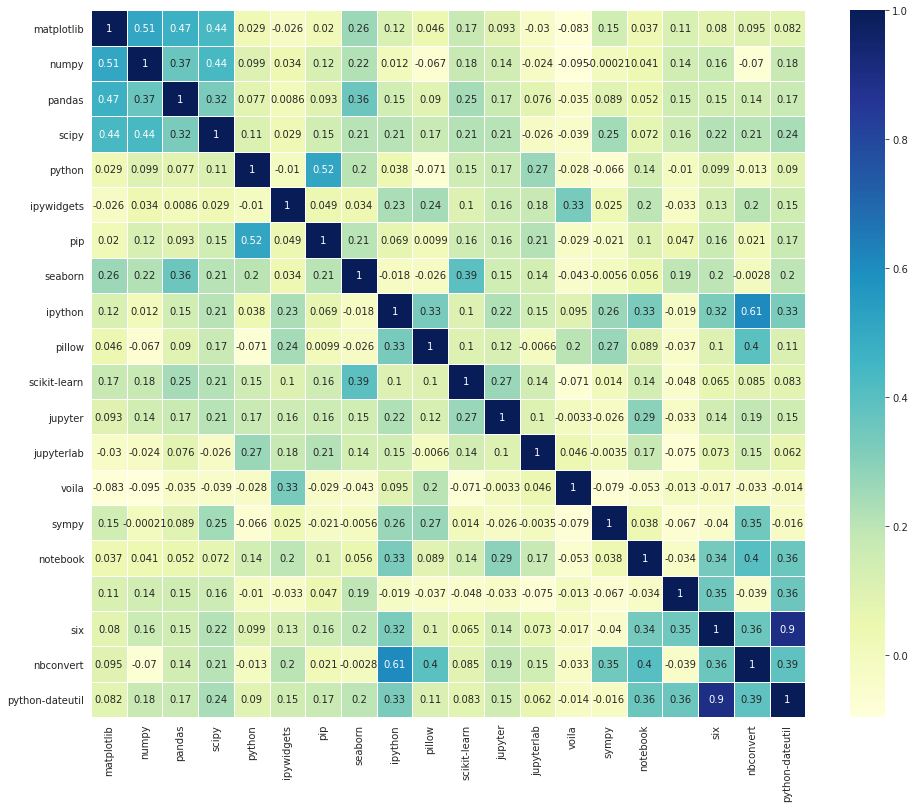

In [59]:
labels = sdf.count().sort_values(ascending=False).head(20).index
plt.figure(figsize=(16,13))
heatmap_df = sdf[labels].notnull().astype('int')
cor = heatmap_df.corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu", linewidths=.5)

<AxesSubplot:ylabel='Frequency'>

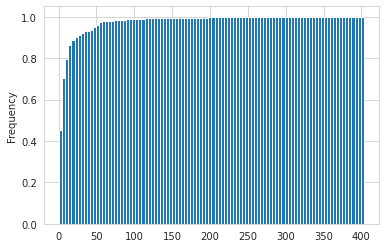

In [60]:
sdf.count(axis=1).plot.hist(cumulative=True, density=1, bins=100)

<AxesSubplot:ylabel='Frequency'>

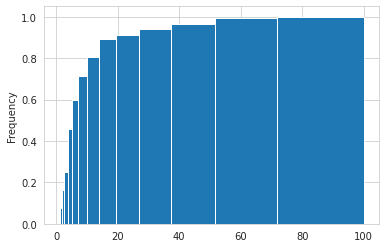

In [61]:
sdf.count(axis=1).plot.hist(cumulative=True, density=1, bins=np.logspace(np.log10(1),np.log10(100), 15))

<AxesSubplot:xlabel='index'>

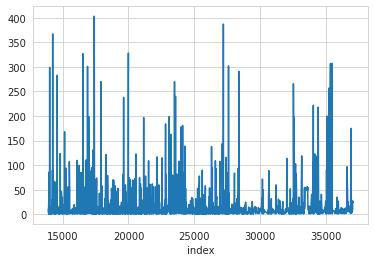

In [63]:
sdf.count(axis=1).plot(x = 'value', y = 'cdf', grid = True)

<a name='veda'></a>
## 11. Library Version EDA

<br>

requested versions:

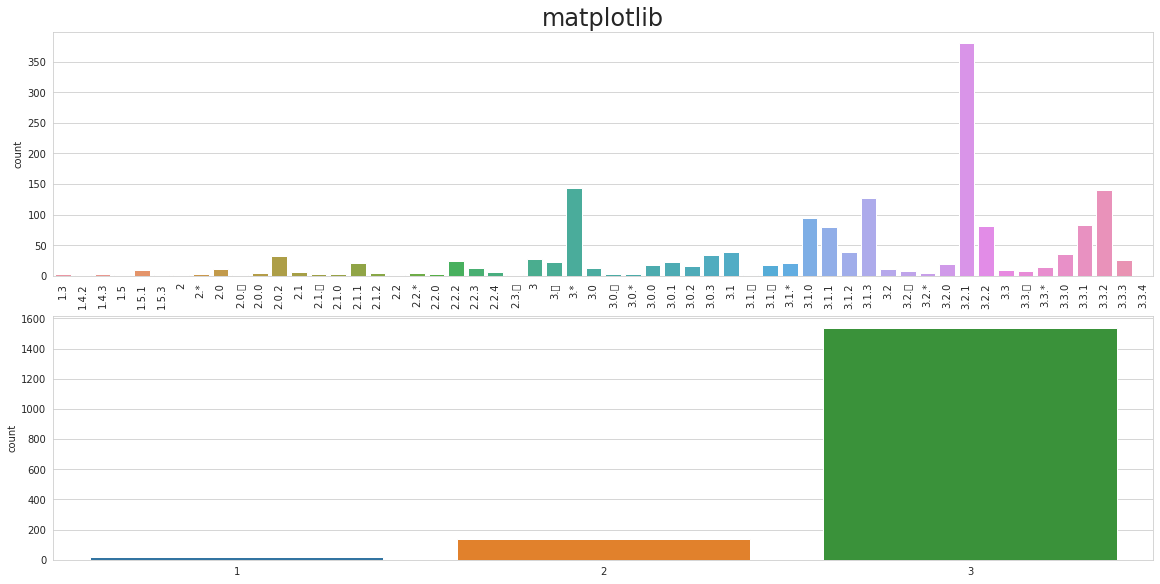

In [151]:
def take_last(splitlist, index):
    try:
        return splitlist[index][-1]
    except:
        return ''

def lib_version_dist(col):
    mb_list = dp_df[col].tolist()
    mb_list = list(filter(lambda a: (a != None) and (a != 'Default'), mb_list))
    sp_list = []
    s0_list = []
    for i in mb_list:
        sp_string = ''
        splitlist = i.split('.')
        if len(splitlist) > 0:
            sp_string = sp_string + take_last(splitlist, 0)
            s0_list.append(sp_string)
            if len(splitlist) > 1:
                sp_string = sp_string + '.' + take_last(splitlist, 1)
                if len(splitlist) > 2:
                    sp_string = sp_string + '.' + take_last(splitlist, 2)

        sp_list.append(sp_string)

    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    fig.set_size_inches(16, 8)
    #plot1 = plt.figure(figsize=(20,10))
    axs[0].set_title(col, fontsize=24)
    chart1 = sns.countplot(np.sort(sp_list), ax=axs[0])
    _ = chart1.set_xticklabels(chart1.get_xticklabels(), rotation=90)
    chart2 = sns.countplot(np.sort(s0_list), ax=axs[1])
    _ = chart2.set_xticklabels(chart2.get_xticklabels(), rotation=0)
    fig.show()

    
lib_version_dist("matplotlib")

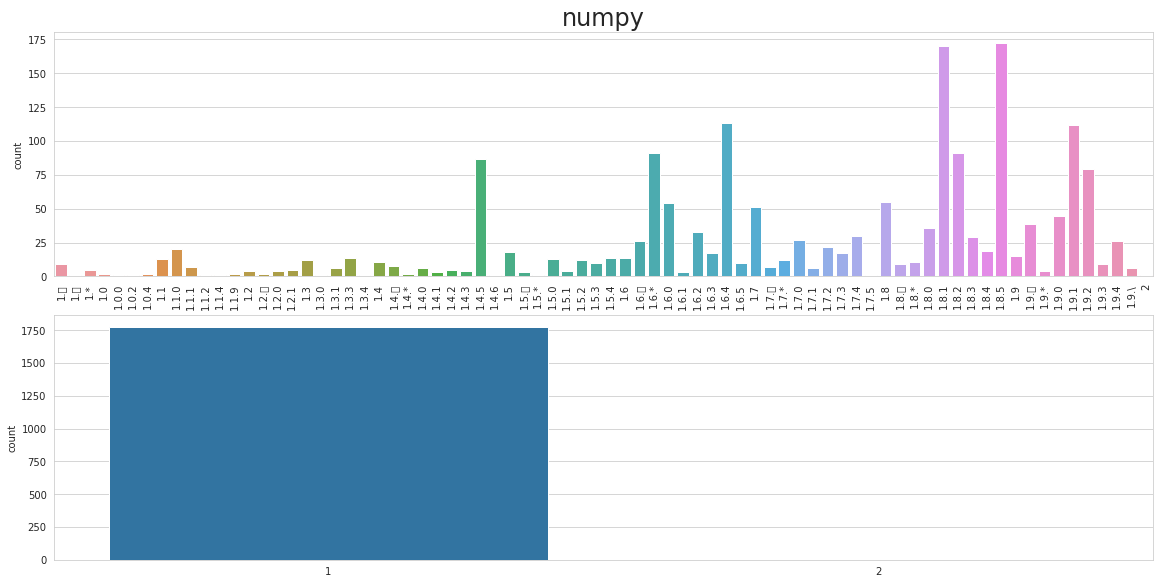

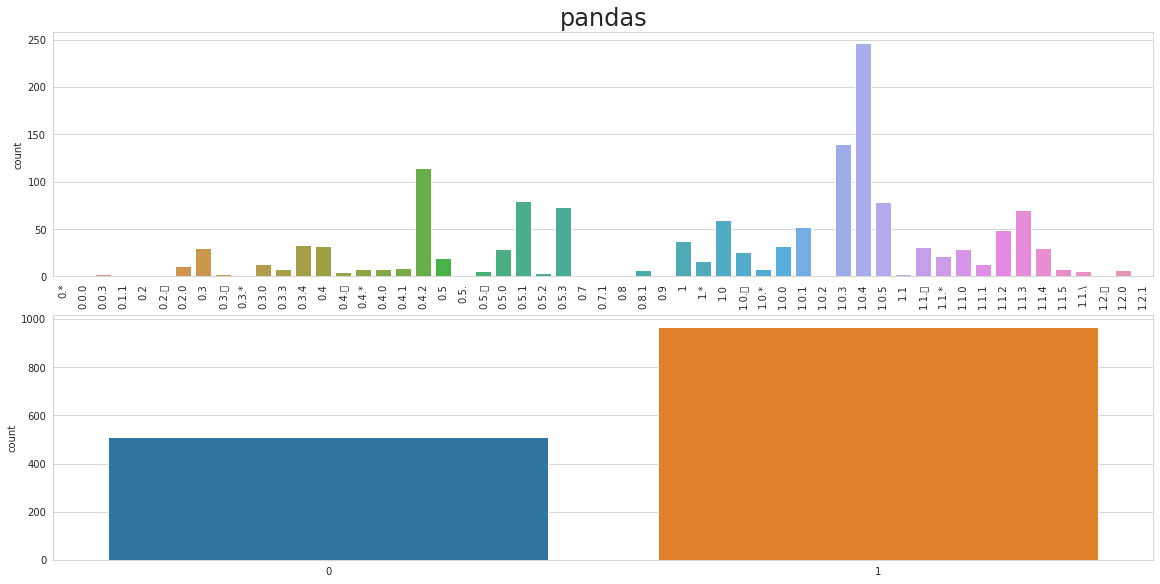

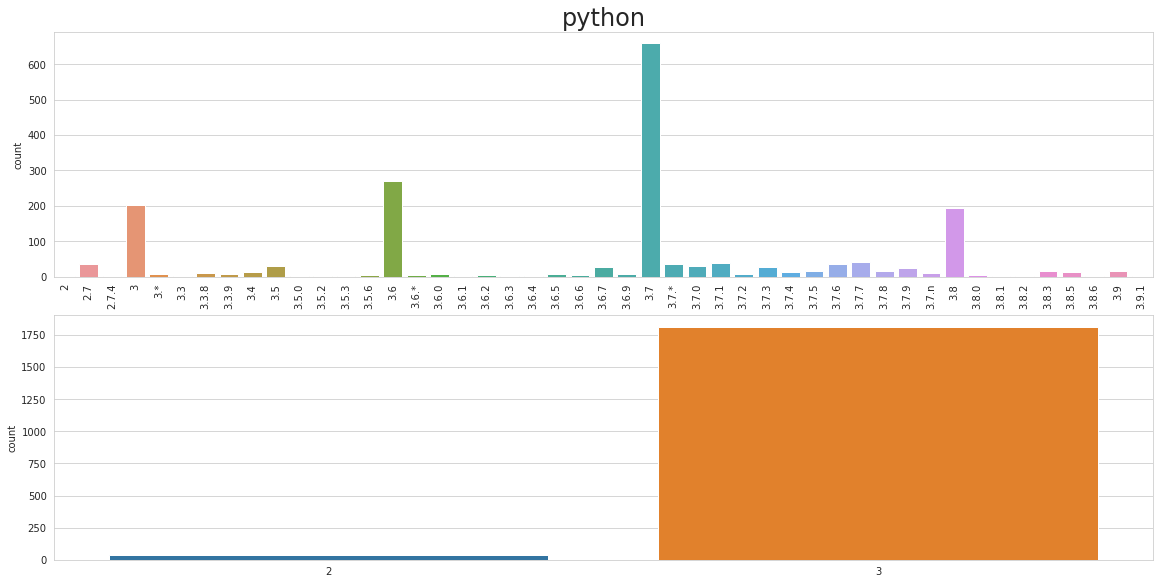

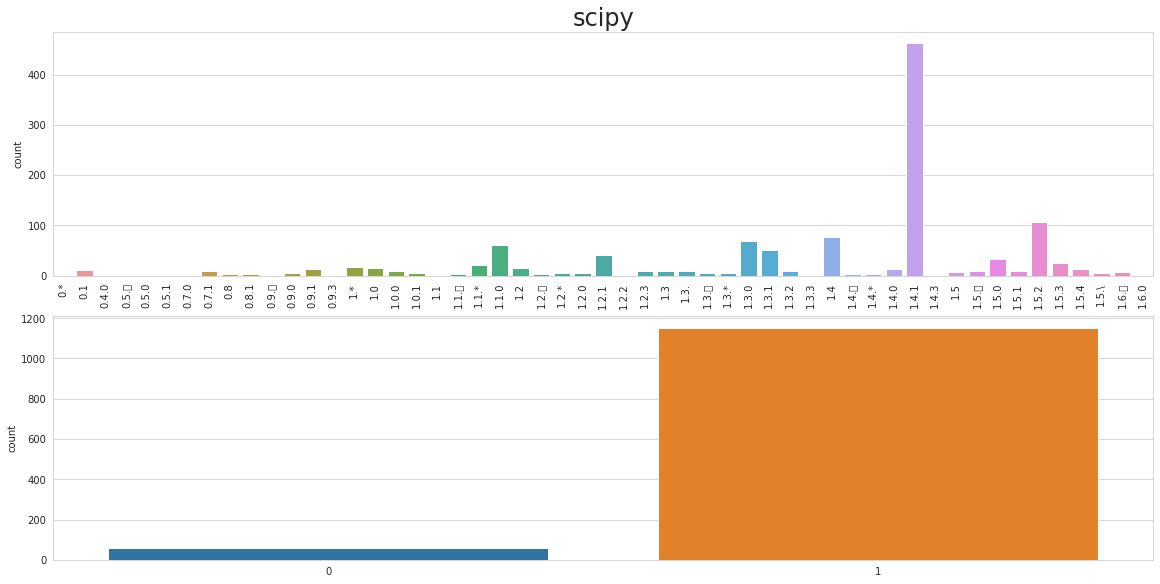

In [152]:
for i in ['numpy', 'pandas', 'python', 'scipy']:
    lib_version_dist(i)

<a name='cpdiff'></a>
## 12. Conda/pip differences

<br>

<a name='hgg'></a>
## 13. Heatmap Graph generation

<br>

In [169]:
hgg_labels = sdf.count().sort_values(ascending=False).head(200).index
hgg_df = sdf[hgg_labels].notnull().astype('int')
hgg_df

,matplotlib,numpy,pandas,scipy,python,ipywidgets,pip,seaborn,ipython,pillow,...,appnope,openpyxl,mkl,patsy,nbpresent,hvplot,pyarrow,tabulate,voila-osscar-template,freetype
index,,,,,,,,,,,,,,,,,,,,,
13920,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13922,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13925,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13926,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37026,0,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
37027,0,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
37028,0,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


There's probably a much faster way to do it (this is O(n^2)). I wanted to create something like a heatmap dataframe that has the similarity score between any two columns. Will be using cosine similarity.

In [170]:
a = [1,1,1]
b = [1,1,1]
print(1 - cosine(hgg_df["numpy"], hgg_df["scipy"]))

0.6766428210179566


In [171]:
edge_list = pd.DataFrame(columns= ['Source', 'Target', 'Weight'])
counter = 0
for col1 in hgg_df:
    for col2 in hgg_df:
        if col1 != col2:
            score = 1 - cosine(hgg_df[col1], hgg_df[col2])
            edge_list = edge_list.append({'Source': col2, 'Target': col1, 'Weight': score}, ignore_index=True)
        counter += 1
        if counter % 10000 == 0:
            print(counter)
            
edge_list

10000
20000
30000
40000


,Source,Target,Weight
0,numpy,matplotlib,0.792168
1,pandas,matplotlib,0.752886
2,scipy,matplotlib,0.679701
3,python,matplotlib,0.415842
4,ipywidgets,matplotlib,0.330488
...,...,...,...
39795,nbpresent,freetype,0.010364
39796,hvplot,freetype,0.020728
39797,pyarrow,freetype,0.051820
39798,tabulate,freetype,0.000000


<a name='nex'></a>
## 14. NetworkX Setup

<br>

In [175]:
D = nx.convert_matrix.from_pandas_edgelist(edge_list,'Source','Target',['Weight'],nx.DiGraph)
G = nx.DiGraph.to_undirected(D)

In [176]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 200\nNumber of edges: 19900\nAverage degree: 199.0000'

In [204]:
threshold = 0.13
edge_list[edge_list["Weight"] > threshold]

,Source,Target,Weight
0,numpy,matplotlib,0.792168
1,pandas,matplotlib,0.752886
2,scipy,matplotlib,0.679701
3,python,matplotlib,0.415842
4,ipywidgets,matplotlib,0.330488
...,...,...,...
39788,libffi,freetype,0.847336
39789,hdf5,freetype,0.430911
39790,ncurses,freetype,0.841302
39793,mkl,freetype,0.497469


In [205]:
edge_list_trimmed = edge_list[edge_list["Weight"] > threshold]
Dt = nx.convert_matrix.from_pandas_edgelist(edge_list_trimmed,'Source','Target',['Weight'],nx.DiGraph)
Gt = nx.DiGraph.to_undirected(Dt)

<a name='nv'></a>
## 15. Bokeh Visualizations

<br>

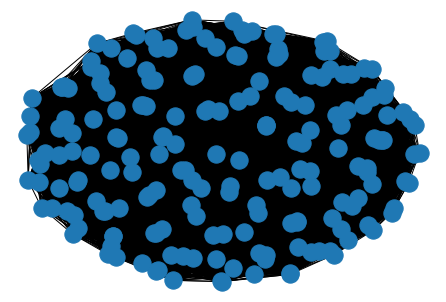

In [192]:
nx.draw(G)

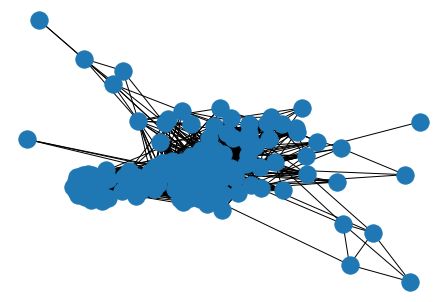

In [206]:
nx.draw(Gt)

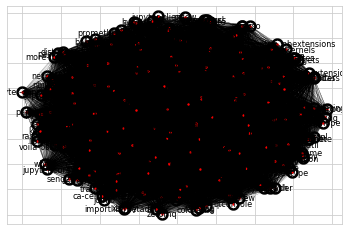

In [194]:
options = {
    "font_size": 8,
    "node_size": 6,
    "node_color": "red",
    "edgecolors": "black",
    "linewidths": 10,
    "width": 0.15,
}

#plt.figure(3,figsize=(40,40)) 
nx.draw_networkx(G, **options)
#plt.show()

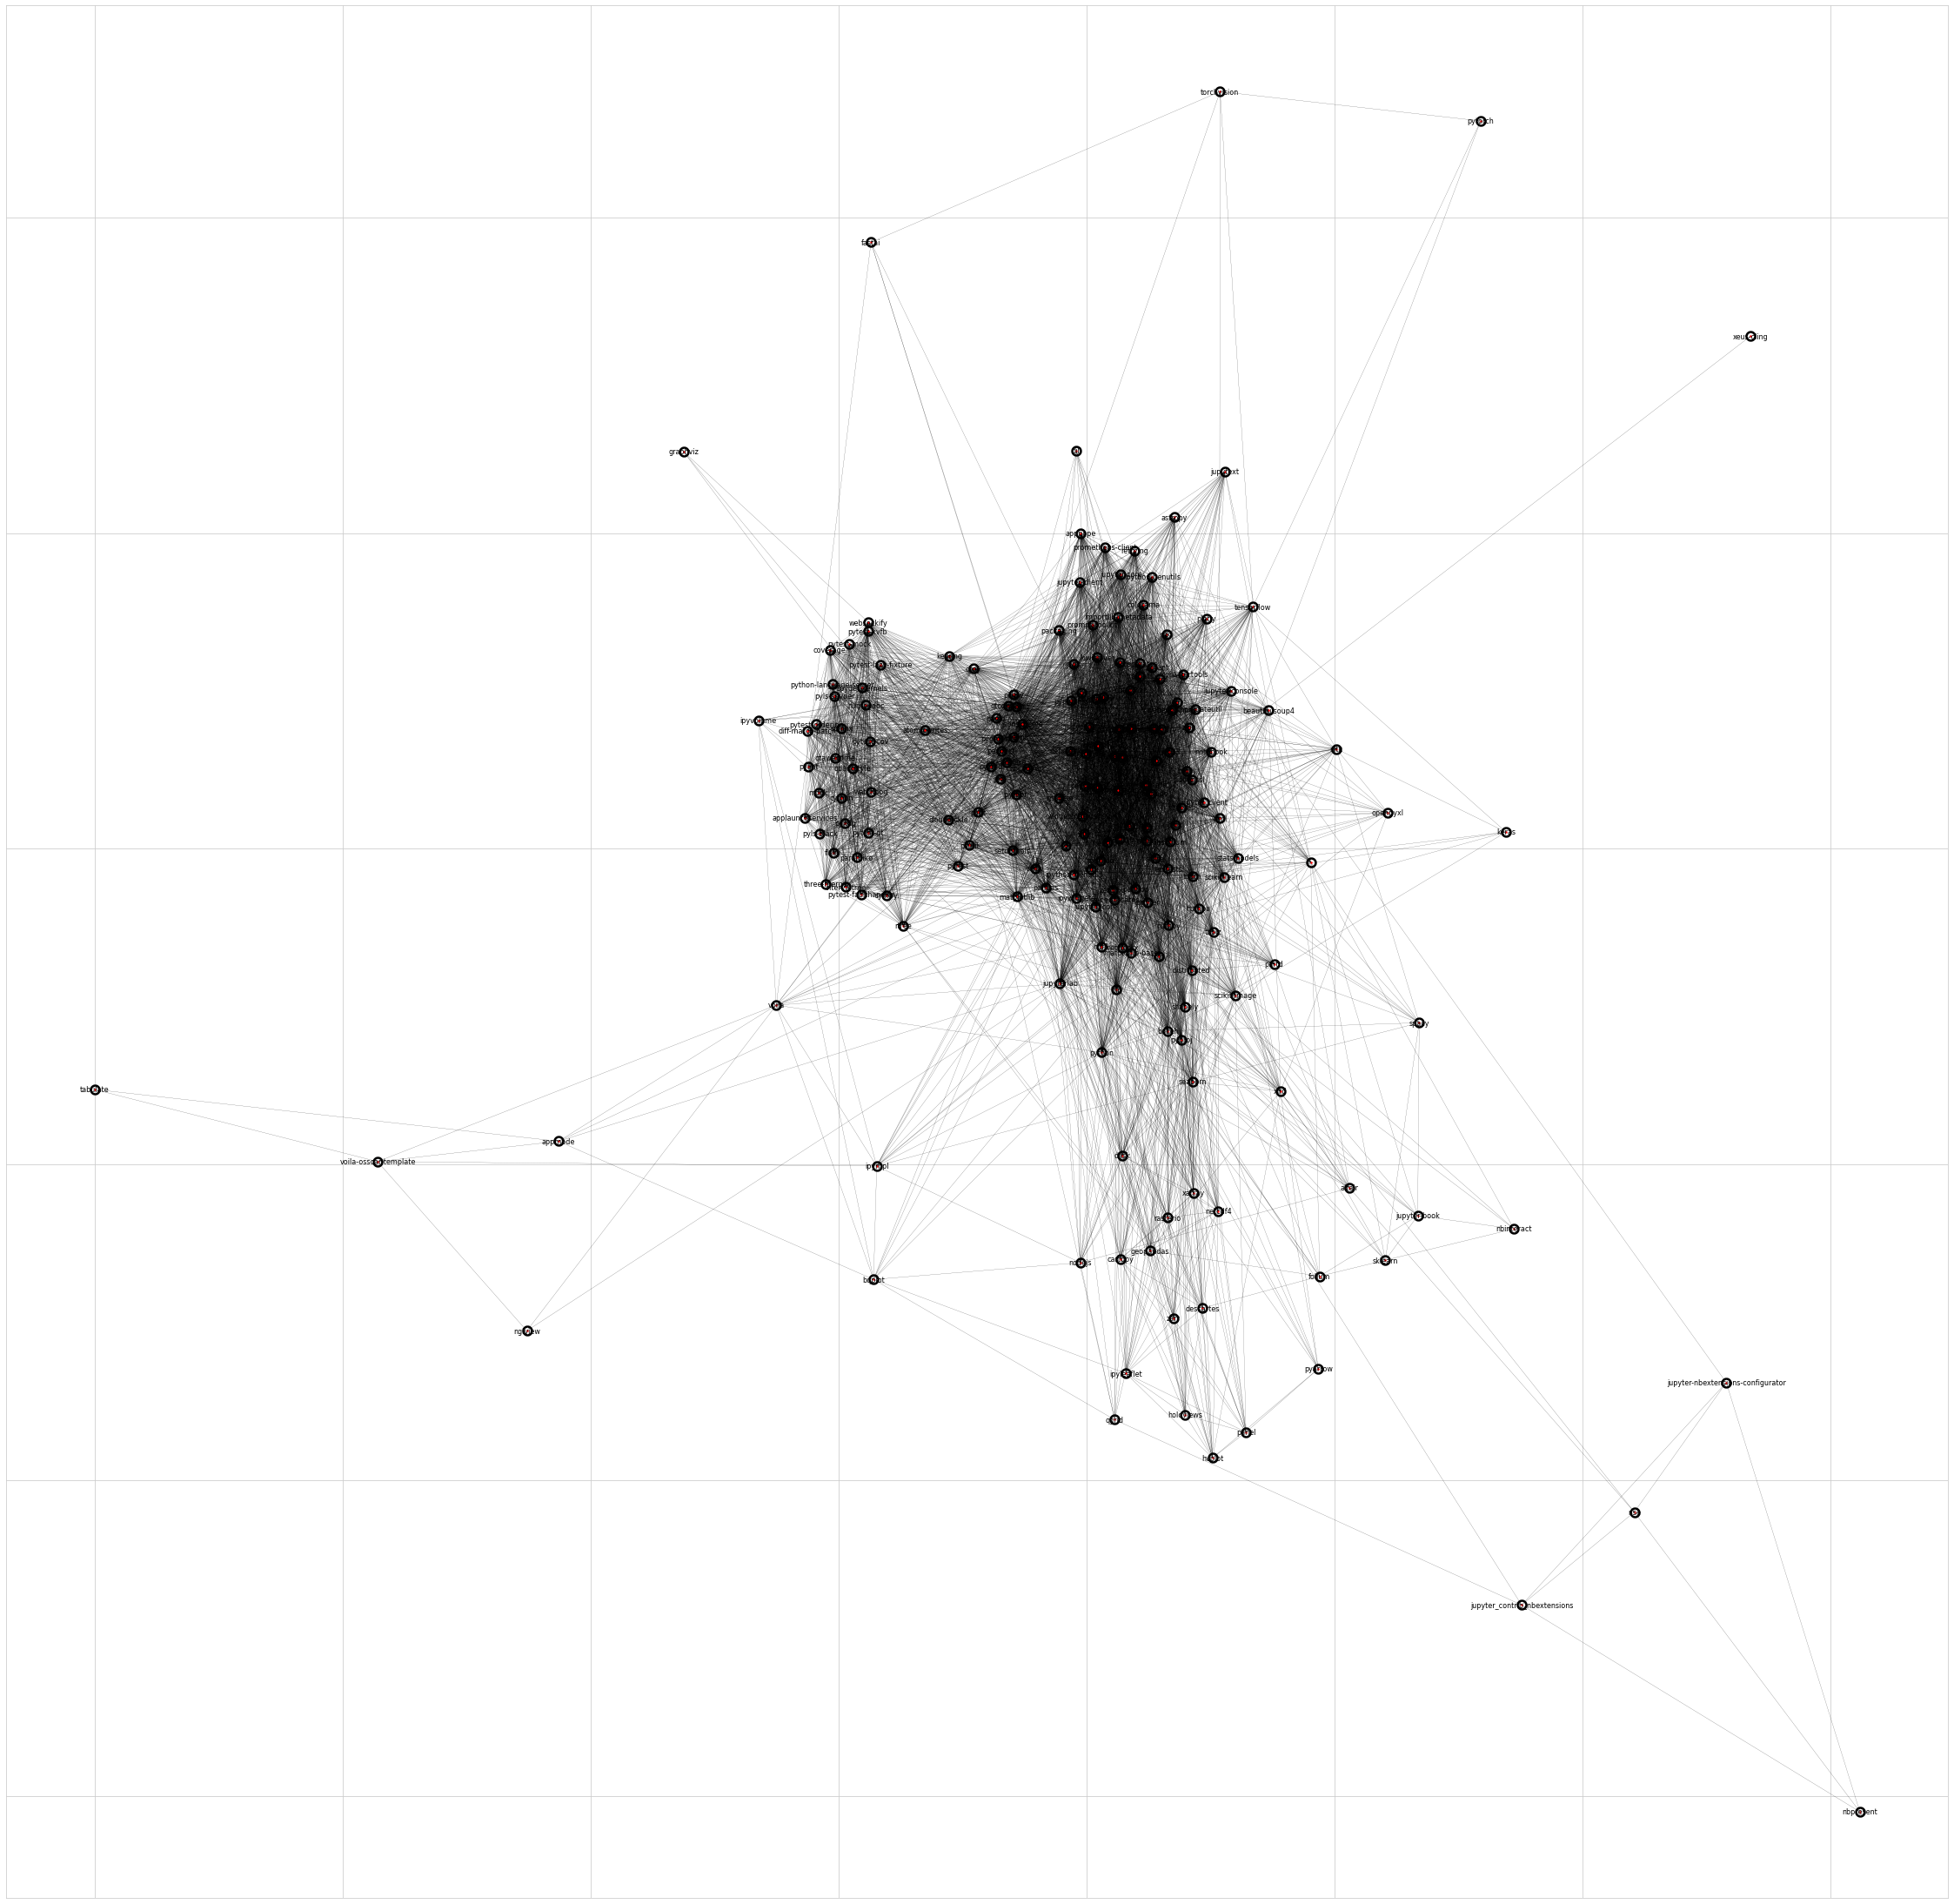

In [207]:
plt.figure(3,figsize=(40,40)) 
nx.draw_networkx(Gt, **options)